# Basic System

This notebook provides code for implementing a very simple machine learning system for named entity recognition.
It uses logistic regression and one feature (the token itself).
Links to information about the packages are provided. Your job is to document the code and use it to train a system. You can then use your evaluation code to provide the first basic evaluation of your system.

*Note:* In the next assignment, you can use this as a basis to experiment with more features and more machine learning methods.

### About this Notebook:
- The notebook is structured similarly to the assignment pdf. Each question contains suggestions to help guide you, but remember to follow the requirements in the PDF for your final answers.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import sys

# If you want to include other modules, you can add them here
# Please note the recommendations on using modules in the Programming General Guidelines

#recommended resource for examples: https://scikit-learn.org/stable/modules/feature_extraction.html

from collections import defaultdict, Counter
import matplotlib.pyplot as plt

## 2.1. Load and inspect the data
**Suggestions:**
 - Download the following files form from canvas ,and place them in the folder "`./data/conll2003`":
   - `conll2003.train.conll`, `conll2003.test.conll`, `conll2003.dev.conll`


In [8]:
def extract_features(inputfile):
    """TODO fill in docstring"""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                feature_dict = {'token':token}
                data.append(feature_dict)
    return data

In [19]:
def extract_features_and_labels(trainingfile):
    data = []
    targets = []
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split() # just extract more features in this function to avoid more loops down the road
            if len(components) > 0:  
                token = components[0]
                pos_tag = components[1]
                chunk_tag = components[2]
                ner_tag = components[3]

                feature_dict = {
                    'token': token,
                    'pos_tag': pos_tag,
                    'chunk_tag': chunk_tag,
                    'capitalized': token[0].isupper(),
                    'contains_digit': any(char.isdigit() for char in token),
                    'token_length': len(token)
                }
                
                data.append(feature_dict)
                targets.append(ner_tag)
    return data, targets

In [10]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"

In [20]:
data, targets = extract_features_and_labels(train_file)

In [21]:
print(f"First 3 Tokens: {data[:3]} and their targets: {targets[:3]}")

First 3 Tokens: [{'token': 'EU', 'pos_tag': 'NNP', 'chunk_tag': 'B-NP', 'capitalized': True, 'contains_digit': False, 'token_length': 2}, {'token': 'rejects', 'pos_tag': 'VBZ', 'chunk_tag': 'B-VP', 'capitalized': False, 'contains_digit': False, 'token_length': 7}, {'token': 'German', 'pos_tag': 'JJ', 'chunk_tag': 'B-NP', 'capitalized': True, 'contains_digit': False, 'token_length': 6}] and their targets: ['B-ORG', 'O', 'B-MISC']


## 2.2. Data analysis: feature and label distributions
**Suggestions:**

- Inspect which unique NER labels there are and plot their distribution (tip: look into the `Counter()`)
- Evaluate the samples per class to answer the questions in the pdf

### NER Label Distribution

Distribution of NER Labels:
B-ORG: 6321
O: 169578
B-MISC: 3438
B-PER: 6600
I-PER: 4528
B-LOC: 7140
I-ORG: 3704
I-MISC: 1155
I-LOC: 1157


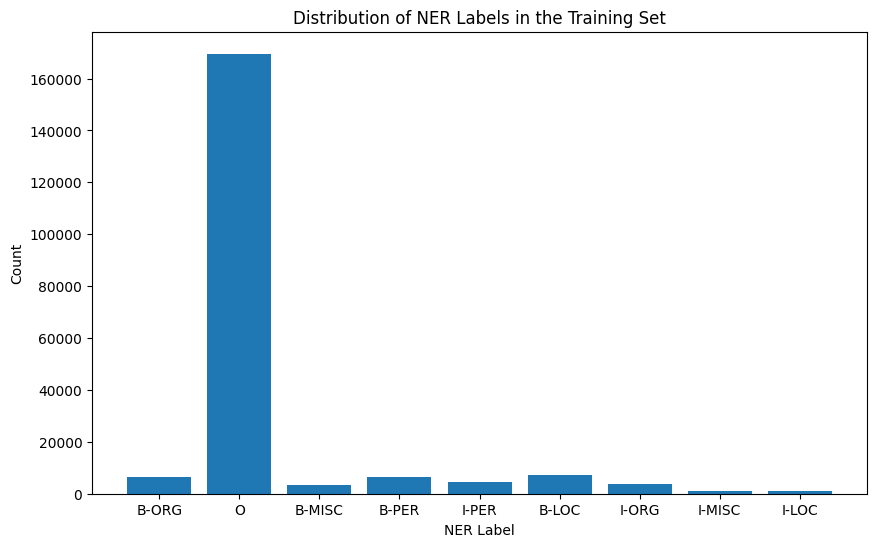

In [18]:
counts = Counter(targets)
print("Distribution of NER Labels:")

for label, count in counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.xlabel("NER Label")
plt.ylabel("Count")
plt.title("Distribution of NER Labels in the Training Set")
plt.show()


## 2.3. Evaluation

**Suggestions:**
- Create a sample file with the ground_truth features and labels `sample_gt.conll` and a sample prediction file with the predictions `sample_pred.conll`.
- Create a function functions to calculate different metrics from two files: e.g. precision(), recall(), f-score(), confusion_matrix(). (Note you can use packages, e.g. `sklearn`)

## 2.4. Train and evaluate basic NERC system
**Suggestions:**
- Train the Logistic regression classifier on your dataset and evaluate the performance on your various metrics.
- Transfer your code to a python file 

In [4]:
def create_classifier(train_features, train_targets):
    """TODO fill in docstring"""
    logreg = LogisticRegression()
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = logreg.fit(features_vectorized, train_targets)
    
    return model, vec

In [5]:
def classify_data(model, vec, inputdata, outputfile):
    """TODO fill in docstring"""
    features = extract_features(inputdata)
    features = vec.transform(features)
    predictions = model.predict(features)
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()

### (**optional**) 2.4.2 Convert to a python file:
- This is part is optional for now but will be required for assignment 2, so it is good practice.

Description:
- To convert the code to a python file, you should place all the relevant functions in one `.py` file.
- Add the following lines to the bottom, which ensure that if you call the function from a terminal, the lines within it will be exectued:


In [ ]:
def main(argv=None):
    """TODO fill in docstring"""

    #a very basic way for picking up commandline arguments
    if argv is None:
        argv = sys.argv
        
    #Note 1: argv[0] is the name of the python program if you run your program as: python program1.py arg1 arg2 arg3
    #Note 2: sys.argv is simple, but gets messy if you need it for anything else than basic scenarios with few arguments
    #you'll want to move to something better. e.g. argparse (easy to find online)
    
    
    #you can replace the values for these with paths to the appropriate files for now, e.g. by specifying values in argv
    #argv = ['mypython_program','','','']
    trainingfile = argv[1]
    inputfile = argv[2]
    outputfile = argv[3]
    
    training_features, gold_labels = extract_features_and_labels(trainingfile)
    ml_model, vec = create_classifier(training_features, gold_labels)
    classify_data(ml_model, vec, inputfile, outputfile)

# uncomment this when using this in a script    
if __name__ == '__main__':
    # Code below is executed when this python file is called from terminal
    main()


In [ ]:
# remember that the first element of the list is not used 
# (since this is the `python command when the args are read from sys.argv)
# make sure to complete the rest of the list assigned to args correctly
args = ['python']
main(args)